In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch.nn.functional import softmax

In [4]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

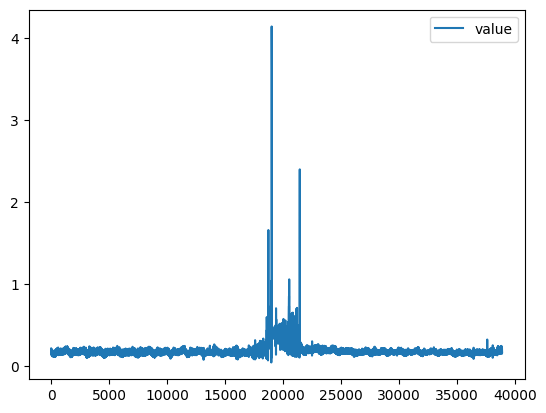

In [5]:
data.plot()

In [6]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment4/online-learning-DLinear']

In [7]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size-1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size-1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [8]:
A=FloatTensor([[[1,2,3]],[[4,5,6]]])
B=FloatTensor([[[1,2,3]],[[4,5,6]]])
C=(A*B).sum(dim=2).view(-1,1,1)
D=FloatTensor([[[1,2,3]],[[4,5,6]]])
E=FloatTensor([[[1,2,3]],[[1,2,3]]])
F=(-1*(torch.abs(D-E).sum(dim=2))).view(-1,1,1)

print(F*E)
print(D[:,:,0:2])
#list_f = [C,F]
# for i in list_f:
#     print(i)
#torch.cat([C,F],dim=2)

torch.cat([FloatTensor(),C],dim=2)

tensor([[[ -0.,  -0.,  -0.]],

        [[ -9., -18., -27.]]])
tensor([[[1., 2.]],

        [[4., 5.]]])


tensor([[[14.]],

        [[77.]]])

In [9]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        self.SMALLKERNEL = 61
        
        # Decomposition Kernel Size
        kernel_size = 61
        self.stride = 1
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        

        self.Linear_Seasonal = nn.Linear(2*self.SMALLKERNEL,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_plus = nn.Linear(2,1)
        
        
#         self.Kernel_Linear = nn.ModuleList()
#         for i in range(seasonal_init.size(-1)//SMALLKERNEL):
#             self.Kernel_Linear.append(nn.Linear())
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device)

        STANDARD = seasonal_init[:,:,-self.SMALLKERNEL:]
        Score_List = []
        Vector_List = []
    
        
        for i in range(self.SMALLKERNEL,seasonal_init.size(-1)-self.SMALLKERNEL+1):
            Comparison_Vector = seasonal_init[:,:,-i-self.SMALLKERNEL:-i]
            Vector_List.append(Comparison_Vector)
            score = (-1*(torch.abs(STANDARD-Comparison_Vector).sum(dim=2))).view(-1,1,1) 
            # 거리를 구한후에 -를 붙여준다
            # 이를 통해 그래프의 모양이 많이 차이나는 것은 가중치를 덜 받게 된다
            Score_List.append(score)
            
        score_tensor = FloatTensor().to(self.device)
        value_tensor = torch.zeros(size=(seasonal_init.size(0),1,self.SMALLKERNEL)).to(self.device)
        
        for i in Score_List:
            score_tensor = torch.cat([score_tensor,i],dim=2)
        
#         print(score_tensor.size())
        Prob_Score = softmax(score_tensor,dim=2)
        
        
#         print(Prob_Score[:,:,0].view(-1,1,1).size())
#         print(Vector_List[0].size())
#         print(value_tensor.size())
        for i in range(Prob_Score.size(2)):
            value_tensor=value_tensor+((Prob_Score[:,:,i].view(-1,1,1))*Vector_List[i])
            # 빈 Tensor와는 덧셈과 같은 텐서연산이 불가능하다
            
        seasonal_input = torch.cat([value_tensor,STANDARD],dim=2)
        seasonal_output = self.Linear_Seasonal(seasonal_input)    
        trend_output = self.Linear_Trend(trend_init)
        new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [11]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_595296/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [12]:
torch.manual_seed(42)

In [13]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.99 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [14]:
torch.manual_seed(42)

In [15]:
out_list = []
loss_list = []
time_list1 = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    Start = time.time()
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()   
        
    End = time.time()
    
    time_list1.append(End-Start)
    
    scheduler.step() #schedular update
    
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.9000e-05.
smape 10.144464765724383 %
Adjusting learning rate of group 0 to 9.8010e-05.
smape 9.787183055839343 %
Adjusting learning rate of group 0 to 9.7030e-05.
smape 9.658120832248041 %
Adjusting learning rate of group 0 to 9.6060e-05.
smape 9.581637849584657 %
Adjusting learning rate of group 0 to 9.5099e-05.
smape 9.53357831122931 %
Adjusting learning rate of group 0 to 9.4148e-05.
smape 9.490670939112267 %
Adjusting learning rate of group 0 to 9.3207e-05.
smape 9.461311372051462 %
Adjusting learning rate of group 0 to 9.2274e-05.
smape 9.434913305336968 %
Adjusting learning rate of group 0 to 9.1352e-05.
smape 9.417253335752683 %
Adjusting learning rate of group 0 to 9.0438e-05.
smape 9.404510826482412 %
Adjusting learning rate of group 0 to 8.9534e-05.
smape 9.389463769413574 %
Adjusting learning rate of group 0 to 8.8638e-05.
smape 9.372462826775529 %
Adjusting learning rate of group 0 to 8.7752e-05.
smape 9.358375002766213 %
Adjusting le

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.050770637009634356 %
SMAPE 17.436133816838264 %
SMAPE 0.06433572221669692 %
SMAPE 0.8811268958716028 %
SMAPE 0.05921885517454939 %
SMAPE 0.4053021243371404 %
SMAPE 5.04815434836928 %
SMAPE 0.1363159135335792 %
SMAPE 0.7076734646296359 %
SMAPE 1.6023050111757582 %
SMAPE 0.8098689651124005 %
SMAPE 12.831558972597124 %
SMAPE 1.1655005450775207 %
SMAPE 4.257033921559923 %
SMAPE 5.216607511043549 %
SMAPE 0.022975736168007188 %
SMAPE 15.395208343863487 %
SMAPE 15.773254171013832 %
SMAPE 0.809205256710726 %
SMAPE 0.30454343945041273 %
SMAPE 6.420624511316418 %
SMAPE 14.26984629034996 %
SMAPE 0.09948454921732262 %
SMAPE 3.363276469404809 %
SMAPE 0.11740008998526719 %
SMAPE 6.838408414274453 %
SMAPE 6.2177268750965595 %
SMAPE 2.197891730007541 %
SMAPE 0.35508645937170513 %
SMAPE 0.023021985035796888 %
SMAPE 0.3995706788118696 %
SMAPE 12.93804135173559 %
SMAPE 4.977737306871859 %
SMAPE 0.8014236683008562 %
SMAPE 0.07554019623387376 %
SMAPE 3.841815230436623 %
SMAPE 8.27427814155817 %
SMA

SMAPE 0.3714533534248403 %
SMAPE 4.545309974666452 %
SMAPE 3.819732689938973 %
SMAPE 2.769004379159014 %
SMAPE 0.3576210815281229 %
SMAPE 0.6288219345860853 %
SMAPE 0.3718015519898472 %
SMAPE 0.03698415847156866 %
SMAPE 1.9947809050427165 %
SMAPE 5.721048455685377 %
SMAPE 22.630584686994553 %
SMAPE 0.08523162168488341 %
SMAPE 1.0190386400716989 %
SMAPE 0.18863174951184192 %
SMAPE 0.0338288891935008 %
SMAPE 0.3836386060947916 %
SMAPE 2.1565614910487056 %
SMAPE 0.11892107212253224 %
SMAPE 0.8747718146496481 %
SMAPE 1.246276224086614 %
SMAPE 0.019540589081145754 %
SMAPE 2.93253283679951 %
SMAPE 0.5890571244271996 %
SMAPE 1.278212479632657 %
SMAPE 8.792120844125748 %
SMAPE 0.1020918310936736 %
SMAPE 0.4602559297927656 %
SMAPE 7.783286198973656 %
SMAPE 5.94628767406266 %
SMAPE 0.7450590886528516 %
SMAPE 0.5435586187531953 %
SMAPE 1.073305885809532 %
SMAPE 1.3137739256053464 %
SMAPE 0.42294024397460817 %
SMAPE 3.9531735501950607 %
SMAPE 1.0960631284942792 %
SMAPE 0.6892572816013853 %
SMAPE 0

SMAPE 0.4670220856905871 %
SMAPE 0.7786258791311411 %
SMAPE 1.3121979527668373 %
SMAPE 2.534084322522176 %
SMAPE 2.0058706384152174 %
SMAPE 1.658892269959324 %
SMAPE 0.24662209928737866 %
SMAPE 8.778819151222706 %
SMAPE 5.716741314157844 %
SMAPE 1.000652440234262 %
SMAPE 1.4137243763343577 %
SMAPE 0.033983079712243125 %
SMAPE 0.1869075144247745 %
SMAPE 1.2798388769674602 %
SMAPE 0.24645759408304002 %
SMAPE 0.8977030162059236 %
SMAPE 1.4616788074672513 %
SMAPE 0.025411911745322868 %
SMAPE 0.48021471390563875 %
SMAPE 3.0247111222706735 %
SMAPE 1.442548540071357 %
SMAPE 7.037596423178911 %
SMAPE 2.3240949693135917 %
SMAPE 6.17173240826196 %
SMAPE 0.022549981310021394 %
SMAPE 1.328520619066353 %
SMAPE 1.875458803944639 %
SMAPE 0.7369146971459486 %
SMAPE 1.4123901064158417 %
SMAPE 2.5708713153144345 %
SMAPE 4.008161807432771 %
SMAPE 0.9153871556118248 %
SMAPE 4.659157944843173 %
SMAPE 1.2716920376915368 %
SMAPE 0.618291178208267 %
SMAPE 0.6079495254234644 %
SMAPE 0.2827720430541376 %
SMAPE 

SMAPE 0.19372011852226478 %
SMAPE 1.333148428664117 %
SMAPE 1.5627219767739005 %
SMAPE 5.147484189947136 %
SMAPE 0.2158092073264015 %
SMAPE 0.7294313898491964 %
SMAPE 0.052432830425459535 %
SMAPE 2.79997974212165 %
SMAPE 0.17159477874065487 %
SMAPE 0.0750008400225397 %
SMAPE 0.2735866321695539 %
SMAPE 0.12461720666749443 %
SMAPE 0.7849873661652964 %
SMAPE 2.425120035877626 %
SMAPE 2.61453981413797 %
SMAPE 0.0866477795773335 %
SMAPE 1.291032310382434 %
SMAPE 0.0817166647425438 %
SMAPE 0.8680267340332648 %
SMAPE 0.3315450628201688 %
SMAPE 0.025703252007588166 %
SMAPE 2.601858913767501 %
SMAPE 0.5710398985265783 %
SMAPE 0.049051489108990154 %
SMAPE 2.2766019974114897 %
SMAPE 0.5020892071074741 %
SMAPE 1.3819704970774183 %
SMAPE 0.5782042141763668 %
SMAPE 1.3224408044034135 %
SMAPE 2.6930083471233957 %
SMAPE 5.244718972593546 %
SMAPE 0.6883778883490095 %
SMAPE 3.4290701029822226 %
SMAPE 0.6874770683656379 %
SMAPE 0.6888010480361118 %
SMAPE 0.044459733781636146 %
SMAPE 0.8985015478419882 %


SMAPE 0.445704493732137 %
SMAPE 1.9387885959549749 %
SMAPE 0.010609115025317806 %
SMAPE 1.746941514262289 %
SMAPE 2.890320823993534 %
SMAPE 0.28352842114873056 %
SMAPE 4.233134459704161 %
SMAPE 0.5222997856226357 %
SMAPE 0.22622148211445392 %
SMAPE 1.2704257401005634 %
SMAPE 0.8778527197573567 %
SMAPE 3.442073964278279 %
SMAPE 0.9102341508369136 %
SMAPE 0.6352200802634798 %
SMAPE 0.24425633050464057 %
SMAPE 2.5827967998047825 %
SMAPE 2.4727217294857837 %
SMAPE 0.6366103628733981 %
SMAPE 0.056657428410460405 %
SMAPE 0.499115119803264 %
SMAPE 0.008163176050061338 %
SMAPE 1.1440117002694024 %
SMAPE 0.06776519703493022 %
SMAPE 1.1553650079254112 %
SMAPE 2.375311995319862 %
SMAPE 0.06662441565242716 %
SMAPE 0.9309239944282127 %
SMAPE 2.0943062489070883 %
SMAPE 0.7265188769451925 %
SMAPE 0.39299813412981166 %
SMAPE 2.9759043090743944 %
SMAPE 0.15228904202547255 %
SMAPE 0.9057613460427092 %
SMAPE 1.5922367284510983 %
SMAPE 1.32610365072469 %
SMAPE 0.22461400308247903 %
SMAPE 1.105562360868134

SMAPE 0.1652440361367553 %
SMAPE 0.44409258240102645 %
SMAPE 0.8376602702937817 %
SMAPE 0.8999110495096829 %
SMAPE 1.291157148324146 %
SMAPE 0.8845923992539609 %
SMAPE 2.4792427854197285 %
SMAPE 0.7320397791845608 %
SMAPE 0.4728795734945379 %
SMAPE 0.8600600199246742 %
SMAPE 1.7094108765049896 %
SMAPE 2.4125443159718998 %
SMAPE 1.4168785669598947 %
SMAPE 0.3262349660410564 %
SMAPE 0.04354837322455296 %
SMAPE 2.0533188718545716 %
SMAPE 0.9620205473747774 %
SMAPE 0.06566968850779631 %
SMAPE 0.914871789857898 %
SMAPE 0.6596669105251749 %
SMAPE 1.7350523909381081 %
SMAPE 2.8266668605501764 %
SMAPE 1.0129821443788387 %
SMAPE 1.3532615711437757 %
SMAPE 0.33467555764804047 %
SMAPE 0.9225502116387362 %
SMAPE 0.40549616916450754 %
SMAPE 0.6962241796112494 %
SMAPE 0.5410414908856183 %
SMAPE 2.1782148750580745 %
SMAPE 0.009931210957347503 %
SMAPE 0.06666888944985772 %
SMAPE 3.6188325793482363 %
SMAPE 0.9235503616073402 %
SMAPE 0.5931458231689248 %
SMAPE 1.380842658712936 %
SMAPE 0.043093585934457

KeyboardInterrupt: 

In [19]:
len(pred_list)

1768

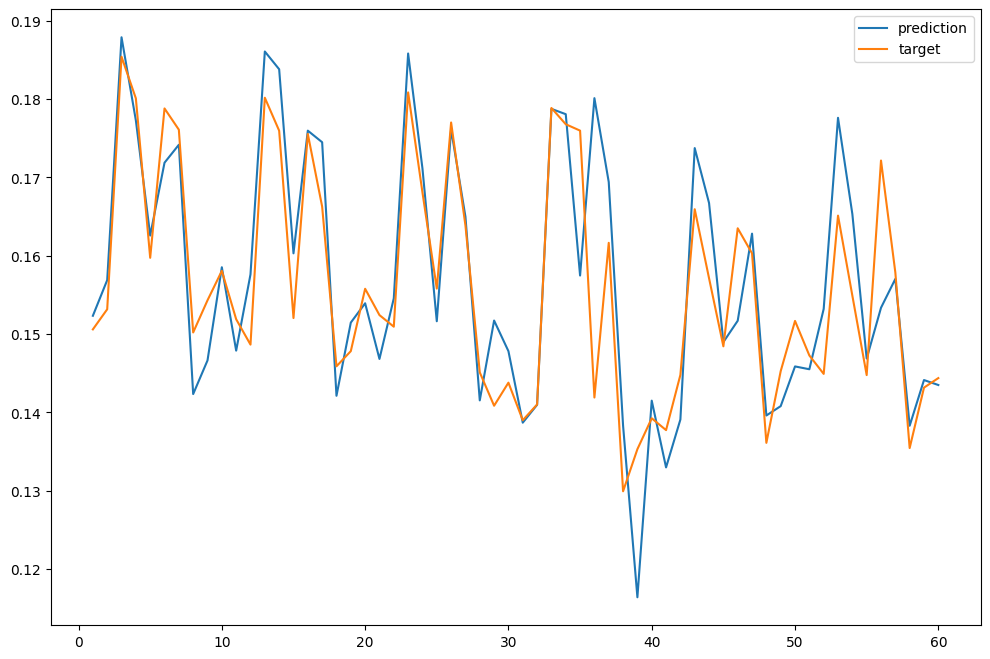

In [20]:
target = data.iloc[-split:]
target=list(target.values.reshape(-1))
target = target[:1768]
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [21]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item()*100,'%')

SMAPE 4.140133783221245 %
RMSE 0.009368897415697575
MAPE 4.1259631514549255 %


In [ ]:
len(pred_list)

In [ ]:
pred_list

In [ ]:
target=list(target.values.reshape(-1))

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[61:121],label='prediction')
axes.plot(np.arange(1,61),target[:2821][61:121],label='target')
axes.legend()

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [ ]:
np.array(pred_list)

In [ ]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

In [ ]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

In [ ]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

In [ ]:
len(time_list)

In [ ]:
np.mean(time_list) 

In [ ]:
np.mean(time_list1) #pretraining 1Epoch 도는데 걸리는 시간